# **Setup**

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB




2022-10-27 10:41:05.758804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-27 10:41:05.759122: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import collections

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal

# **Load data**

In [3]:
def load_data(data_file):
    print('Loading data ...')
    with open(data_file, 'rb') as f:
        pickle_data = pickle.load(f)
        x_data = pickle_data['x_data']
        y_data = pickle_data['y_data']
    print('Data loaded.')
    return x_data, y_data

In [5]:
data_file = '/Users/kevynkrancenblum/Desktop/Data Science/Final Project /Facial_emotion_recognition/train_data.p'
images, labels = load_data(data_file)
labels=np.array(labels)
images=np.array(images)
n_samples = labels.shape[0]
print('Total samples:', n_samples)
print('images shape:', images.shape)
print('labels shape:', labels.shape)

Loading data ...
Data loaded.
Total samples: 22795
images shape: (22795, 300, 300)
labels shape: (22795,)


# **Explore data**

In [1]:
emotions = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
num_classes = len(emotions)
print(num_classes)

7


KeyError: 0

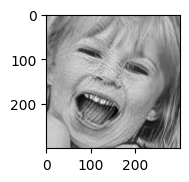

In [18]:
def show_images(images, labels, col=5):
    n = images.shape[0]
    row = np.ceil(n / col)
    fig = plt.figure(figsize=(2*col, 2*row))
    for i in range(n):
        fig.add_subplot(int(row), int(col), i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(emotions[labels[i]])
        plt.xticks([]), plt.yticks([])
    plt.show()

show_images(images[2:3], labels[2:3])

KeyError: 1

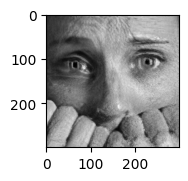

In [16]:
def show_one_emotion(images, labels, id, start=0, num=25):
    image_x = images[labels==id]
    label_x = labels[labels==id]
    show_images(image_x[start:start+num], label_x[start:start+num])

show_one_emotion(images, labels, id=1)

# **Split dataset**

In [19]:
image_train, image_test, label_train, label_test = train_test_split(images, labels, test_size=0.2, random_state=42)
image_train, image_val, label_train, label_val = train_test_split(image_train, label_train, test_size=0.2, random_state=42)

print('Training samples:', label_train.shape[0])
print('Validation samples:', label_val.shape[0])
print('Test samples:', label_test.shape[0])

Training samples: 14588
Validation samples: 3648
Test samples: 4559


# **Upsamling training data**

In [29]:
def upsampling(x, y, strategy):
    (n, w, h) = x.shape
    sm = SMOTE(sampling_strategy=strategy, random_state=42)
    x_flat = x.reshape((n,-1))
    x_up, y_up = sm.fit_resample(x_flat, y)
    n_up = x_up.shape[0]
    x_up = x_up.reshape((n_up,w,h))

    return x_up, y_up

In [30]:
collections.Counter(label_train)

Counter({1: 2712, 4: 2633, 2: 3208, 3: 3197, 0: 2838})

In [31]:
image_train_up, label_train_up = upsampling(image_train, label_train, 'auto')

In [32]:
collections.Counter(label_train_up)

Counter({1: 3208, 4: 3208, 2: 3208, 3: 3208, 0: 3208})

In [33]:
for i in range(num_classes):
    if i == 3:
        continue
    show_one_emotion(image_train_up, label_train_up, id=i, start=4000, num=5)

<Figure size 1000x0 with 0 Axes>

<Figure size 1000x0 with 0 Axes>

<Figure size 1000x0 with 0 Axes>

<Figure size 1000x0 with 0 Axes>

# **Utils**

In [34]:
def one_hot_encoding(labels, num_classes):
    return tf.keras.utils.to_categorical(labels, num_classes)

In [35]:
def reshape_images(images, channel=1, resize=None):
    x = tf.expand_dims(tf.convert_to_tensor(images), axis=3)
    if channel > 1:
        x = tf.repeat(x, channel, axis=3)
    if resize is not None:
        x = tf.image.resize(x, resize)
    return x

In [36]:
def pre_processing(images, labels, num_classes, channel=1, resize=None, one_hot=True):
    x = reshape_images(images, channel, resize)
    y = one_hot_encoding(labels, num_classes)
    return x, y

In [37]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(15, 6))
    plt.rc('font', size=12)
    for n, metric in enumerate(metrics):
        name = metric.capitalize()
        plt.subplot(1,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Training', lw=3, color='navy')
        plt.plot(history.epoch, history.history['val_'+metric], lw=3, label='Validation', color='deeppink')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.title('Model '+name)
        plt.legend()
    plt.show()

In [38]:
def evaluate_class(model, x_test, y_test):
    labels = np.argmax(y_test, axis=1)
    print('{:<15}Accuracy'.format('Emotion'))
    print('-'*23)
    for i in range(num_classes):
        x = x_test[labels==i]
        y = y_test[labels==i]
        loss, acc = model.evaluate(x,  y, verbose=0)
        print('{:<15}{:.1%}'.format(emotions[i], acc))
    print('-'*23)
    loss, acc = model.evaluate(x_test,  y_test, verbose=0)
    print('{:<15}{:.1%}'.format('Overall', acc))

# **Model**

In [39]:
def model_checkpoint_cb(file_path):
    return ModelCheckpoint(
        file_path, monitor='val_accuracy', mode='max',
        save_best_only=True, save_weights_only=True)

In [40]:
x_train, y_train = pre_processing(image_train_up, label_train_up, num_classes)
x_val, y_val = pre_processing(image_val, label_val, num_classes)
x_test, y_test = pre_processing(image_test, label_test, num_classes)

train_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = ImageDataGenerator()

batch_size = 128
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val)

steps_per_epoch = train_generator.n // train_generator.batch_size
input_shape = x_train[0].shape

2022-10-26 12:35:01.189462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-26 12:35:01.189531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# one_batch = train_generator.next()
# one_batch_images = one_batch[0].reshape((128,48,48))
# one_batch_labels = np.argmax(one_batch[1], axis=1)
# show_images(one_batch_images[:25], one_batch_labels[:25])

In [41]:
class VGGNet(Sequential):
    def __init__(self, input_shape, num_classes, checkpoint_path, lr=1e-3):
        super().__init__()
        self.add(Rescaling(1./255, input_shape=input_shape))
        self.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
        self.add(BatchNormalization())
        self.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.5))

        self.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.4))

        self.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.5))

        self.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.4))

        self.add(Flatten())
        
        self.add(Dense(1024, activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(256, activation='relu'))

        self.add(Dense(num_classes, activation='softmax'))

        self.compile(optimizer=Adam(learning_rate=lr),
                    loss=categorical_crossentropy,
                    metrics=['accuracy'])
        
        self.checkpoint_path = checkpoint_path

In [1]:
import cv2
import mediapipe as mp
import numpy as np

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

# Define landmark drawing spec
landmark_drawing_spec = mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=6, circle_radius=4)
connection_drawing_spec = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=6, circle_radius=2)

# Load the image
image = cv2.imread('/Users/kevynkrancenblum/Desktop/Data Science/Final Project/test.png')

# Create a blank black image of the same size
black_image = np.zeros(image.shape, dtype=np.uint8)

# Convert the BGR image to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# To improve performance, optionally mark the image as not writeable to pass by reference.
image.flags.writeable = False

# Initialize holistic model
with mp_holistic.Holistic(static_image_mode=True) as holistic:
    results = holistic.process(image)

# Draw face landmarks on the black image
mp_drawing.draw_landmarks(
    black_image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
    landmark_drawing_spec, connection_drawing_spec)

# Draw right hand landmarks on the black image
mp_drawing.draw_landmarks(
    black_image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
    landmark_drawing_spec, connection_drawing_spec)

# Draw left hand landmarks on the black image
mp_drawing.draw_landmarks(
    black_image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
    landmark_drawing_spec, connection_drawing_spec)

# Draw pose landmarks on the black image
mp_drawing.draw_landmarks(
    black_image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
    landmark_drawing_spec, connection_drawing_spec)

# Show image in OpenCV window
cv2.imshow('MediaPipe Holistic', black_image)

# Keep OpenCV window open until user hits any key
cv2.waitKey(0)
cv2.destroyAllWindows()


objc[57946]: Class CaptureDelegate is implemented in both /Users/kevynkrancenblum/.local/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x15c5824e8) and /Users/kevynkrancenblum/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x15d0c8860). One of the two will be used. Which one is undefined.
objc[57946]: Class CVWindow is implemented in both /Users/kevynkrancenblum/.local/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x15c582538) and /Users/kevynkrancenblum/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x117feca68). One of the two will be used. Which one is undefined.
objc[57946]: Class CVView is implemented in both /Users/kevynkrancenblum/.local/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x15c582560) and /Users/kevynkrancenblum/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x117feca90). One of the two will

In [42]:
model = VGGNet(input_shape, num_classes, 'run/vggnet_up.h5')
model.summary()

Model: "vgg_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 300, 300, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 298, 298, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 298, 298, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 298, 298, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 64)     0   

In [1]:
epochs = 200
cp = model_checkpoint_cb(model.checkpoint_path)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-10)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[lr, es, cp])

NameError: name 'model_checkpoint_cb' is not defined

In [ ]:
plot_metrics(history)

In [ ]:
model.load_weights(model.checkpoint_path)
evaluate_class(model, x_test, y_test)

In [ ]:
%cp /content/project/run/vggnet.h5 /content/gdrive/MyDrive/loopQ/project/saved_models